In [1]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import numpy as np
plt.rcParams.update({'font.family':'serif'})

In [2]:
class ThresholdSwitch():
    R_off: float = 5e10
    R_on: float = 3e4
    V_th: float = 0.45
    V_hold: float = 0.05
    distribs: bool = False
    V_th_dist: float = V_th
    V_hold_dist: float = V_hold
    V_th_std: float = 0.03
    V_hold_std: float = 0.01

    def __init__(self,  R_off = R_off, R_on = R_on, V_th = V_th, V_hold = V_hold) -> None:
        self.R_off = R_off
        self.R_on = R_on
        self.V_th = V_th
        self.V_hold = V_hold
        self.state = 'off'

    def params_distibs(self, distribs = distribs, V_th_std = V_th_std, V_hold_std = V_hold_std) -> None:
        self.distribs = distribs
        self.V_th_std = V_th_std
        self.V_hold_std = V_hold_std

    def get_resistance(self, voltage: float) -> float:
        if (self.state == 'off') and ((voltage) < self.V_th):
            return self.R_off
        elif (self.state == 'off') and ((voltage) > self.V_th):
            self.state = 'on'
            if self.distribs == True:
                self.V_th = np.random.normal(loc = self.V_th_dist, scale = self.V_th_std)
            return self.R_on
        elif (self.state == 'on') and ((voltage) > self.V_hold):
            return self.R_on
        elif (self.state == 'on') and ((voltage) < self.V_hold):
            self.state = 'off'
            if self.distribs == True:
                self.V_hold = np.random.normal(loc = self.V_hold_dist, scale = self.V_hold_std)
            return self.R_off

In [103]:
class ExtendedLIF():
    E: float = 1
    C_m: float = 1e-10
    R_r: float = 1e6
    V_c_init: float = 0

    def __init__(self, ts: ThresholdSwitch, E = E, R_r = R_r, C_m = C_m) -> None:
        self.ts = ts
        self.E = E
        self.R_r = R_r
        self.C_m = C_m

    def calculate(self, time_interval: float = 0.01, dots: int = 100000) -> tuple:
        self.R_ts = [self.ts.get_resistance(self.V_c_init)]
        self.I_r = [self.E / (self.R_r + self.R_ts[0])]
        self.V_c = [self.V_c_init]
        time_array = np.linspace(0, time_interval, dots)
        delta_t = time_array[1] - time_array[0]
        for i in range(1, dots):
            self.V_c.append((self.I_r[i - 1] - self.V_c[i - 1] / self.R_ts[i - 1]) * (delta_t / self.C_m) + self.V_c[i - 1])
            self.R_ts.append(self.ts.get_resistance(self.V_c[i]))
            self.I_r.append(self.E / (self.R_r + self.R_ts[i]))
        return time_array, self.V_c, self.R_ts

In [106]:
ts = ThresholdSwitch(V_hold=0.1, R_off=1e8)
ts.params_distibs(distribs=True, V_hold_std=0.003, V_th_std=0.03)
el = ExtendedLIF(ts=ts, E=1)
t, v, r = el.calculate(time_interval=0.01, dots=5_000_00)

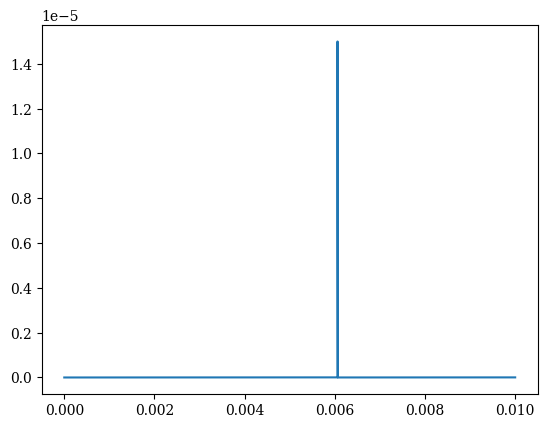

In [107]:
#plt.plot(t, np.array(v))
plt.plot(t, np.array(v) / np.array(r))
plt.xlim()